# Airline Sentiment Analysis (NLP)

**Author:** Franko Ndou

# Overview

Just like any business, airlines have customers to please. Its cruical to make sure that every passenger is left with a positive experience. Social media has allowed us and others to be able to publicly express their opinions about many things including experiences and sentiment towards companies. This is incredibly useful feedback for companies as they can see what the most common complaints are as well as other factors.

# Business Problem

The CCO at JetBlue Airways is closely monitoring social media to understand customer sentiment. They've observed a surge in negative tweets and a decrease in overall customer satisfaction scores in recent months. This trend has raised concerns within JetBlue's management team, as they are committed to providing exceptional service.

The CCO believes that analyzing the sentiment of user tweets can provide valuable insights into the specific issues and areas where JetBlue may be falling short of meeting customer expectations. They are particularly interested in understanding the sentiments associated with JetBlue and how it compares to competitors in the market. To address this, the CCO wants to commission a sentiment analysis NLP model and has chosen to hire you for this project. The model should perform the following tasks:

1. Sentiment Classification: The model should classify user sentiment in tweets as Positive, Neutral, or Negative, providing an overall sentiment assessment.
<br>

2. Key Issue Identification: The model should identify specific issues or concerns mentioned in the negative tweets, such as flight delays, baggage mishandling, or customer service problems.

The sentiment analysis NLP model that you will develop plays a crucial role in helping the CCO and the JetBlue team better understand customer sentiment, pinpoint trouble spots, and make data-driven decisions to enhance the passenger experience and maintain their competitive edge in the airline industry.

# Dataset

The data was made available on [Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment) . The twitter data was scraped from February 2015 for 2 weeks and contains over 14K tweets and their sentiment (positive, neutral, or negative) regarding 6 major airlines in the US.

# EDA and Cleaning

Its always important to start off with checking for any missingness and see what were working with.

In [2]:
# Importing packages
import pandas as pd
import sqlite3 
import numpy as np

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize 
from nltk.tokenize import sent_tokenize 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/ndou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Opening CSV and establish SQL Connection
tweets_csv = pd.read_csv('../data/Tweets.csv')
conn = sqlite3.connect('../data/database.sqlite')

In [4]:
# Checking Schema
pd.read_sql("""
    SELECT *
    FROM sqlite_master
    WHERE type='table';
""", conn)

,type,name,tbl_name,rootpage,sql
0,table,Tweets,Tweets,2,CREATE TABLE Tweets (\n tweet_id INTEGER PR...


In [5]:
# Checking table
pd.read_sql("""
    SELECT *
    FROM Tweets
""", conn)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0000,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0000,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0000,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",
3,567592368451248130,negative,1.0000,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires
4,567594449874587648,negative,1.0000,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,,,Delta,,Oneladyyouadore,,0,@JetBlue I hope so because I fly very often an...,,2015-02-24 11:48:29 -0800,Georgia,Quito
14481,570309340952993796,neutral,1.0000,,,US Airways,,DebbiMcGinnis,,0,@USAirways is a DM possible if you aren't foll...,,2015-02-24 11:48:37 -0800,Missourah,Hawaii
14482,570309345281486848,positive,0.6469,,,Delta,,jaxbra,,0,@JetBlue Yesterday on my way from EWR to FLL j...,,2015-02-24 11:48:38 -0800,"east brunswick, nj",Atlantic Time (Canada)
14483,570310144459972608,negative,1.0000,Customer Service Issue,1,US Airways,,GAKotsch,,0,@USAirways and when will one of these agents b...,,2015-02-24 11:51:48 -0800,,Atlantic Time (Canada)


In [6]:
# Creating DF
tweets_sql = pd.read_sql("""
    SELECT *
    FROM Tweets
""", conn)

In [7]:
# Checking CSV DF
tweets_csv

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


They seem to be the same dataset, we should check so that were not overwhelming ourselves

In [8]:
if tweets_sql.columns.equals(tweets_csv.columns):
    print(True)
else:
    print(False)

True


In [9]:
# Looking for missingness
tweets_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [10]:
tweets_csv.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [11]:
# Looking for Missingness
tweets_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14485 non-null  int64  
 1   airline_sentiment             14485 non-null  object 
 2   airline_sentiment_confidence  14485 non-null  float64
 3   negativereason                14485 non-null  object 
 4   negativereason_confidence     14485 non-null  object 
 5   airline                       14485 non-null  object 
 6   airline_sentiment_gold        14485 non-null  object 
 7   name                          14485 non-null  object 
 8   negativereason_gold           14485 non-null  object 
 9   retweet_count                 14485 non-null  int64  
 10  text                          14485 non-null  object 
 11  tweet_coord                   14485 non-null  object 
 12  tweet_created                 14485 non-null  object 
 13  t

In [12]:
tweets_sql.isna().sum()

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
airline_sentiment_gold          0
name                            0
negativereason_gold             0
retweet_count                   0
text                            0
tweet_coord                     0
tweet_created                   0
tweet_location                  0
user_timezone                   0
dtype: int64

Judging by the fact that we have observed missingness within the SQL dataframe yet our .info() and .isna() tells us there likely isnt. We will be using the CSV file from now on. The CSV is much more straightfoward and will be easier for us to work with. They have the exact same columns and nearly the same number of rows.

I have a strong suspicion that these are likely the same file but im going to see if they match rows

In [13]:
# Define the common columns to compare 
common_columns = ['tweet_id', 'airline_sentiment', 'airline']

# Perform an inner join based on the common columns
matching_rows = pd.merge(tweets_csv, tweets_sql, on=common_columns, how='inner')

# Check if there are matching rows
if not matching_rows.empty:
    print(True)
else:
    print(False)


True


Okay well now we know its the same. Its time for us to clean up the DataFrame

In [14]:
df = tweets_csv 

Are these NaN because theres no negative review attaced to it or becuase its simply not a negative review?

In [15]:
negative_reviews_with_nan_reason = df[(df['airline_sentiment'] == 'negative') & df['negativereason'].isna()]
if not negative_reviews_with_nan_reason.empty:
    print("There are negative reviews with NaN negative reasons.")
else:
    print("There are no negative reviews with NaN negative reasons.")

There are no negative reviews with NaN negative reasons.


In [16]:
# NaN is only seen in non-negative reviews, we can just fill this in with N/A
df['negativereason'].fillna('N/A', inplace=True)

In [17]:
#Dropping all columns that are unnecessary
columns_to_drop = ['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', \
                   'airline_sentiment_confidence', 'negativereason_confidence', 'user_timezone']
df.drop(columns=columns_to_drop, inplace=True)

# We want to be able to tell where these reviews are coming from so Im willing to drop some rows
df.dropna(subset=['tweet_location'], inplace=True)

In [18]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'], format='%Y-%m-%d %H:%M:%S %z')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9907 entries, 2 to 14639
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype                    
---  ------             --------------  -----                    
 0   tweet_id           9907 non-null   int64                    
 1   airline_sentiment  9907 non-null   object                   
 2   negativereason     9907 non-null   object                   
 3   airline            9907 non-null   object                   
 4   name               9907 non-null   object                   
 5   retweet_count      9907 non-null   int64                    
 6   text               9907 non-null   object                   
 7   tweet_created      9907 non-null   datetime64[ns, UTC-08:00]
 8   tweet_location     9907 non-null   object                   
dtypes: datetime64[ns, UTC-08:00](1), int64(2), object(6)
memory usage: 774.0+ KB


In [19]:
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'airline_sentiment' column
df['airline_sentiment'] = label_encoder.fit_transform(df['airline_sentiment'])

# Mapping of labels
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

## Visualizng the dataset

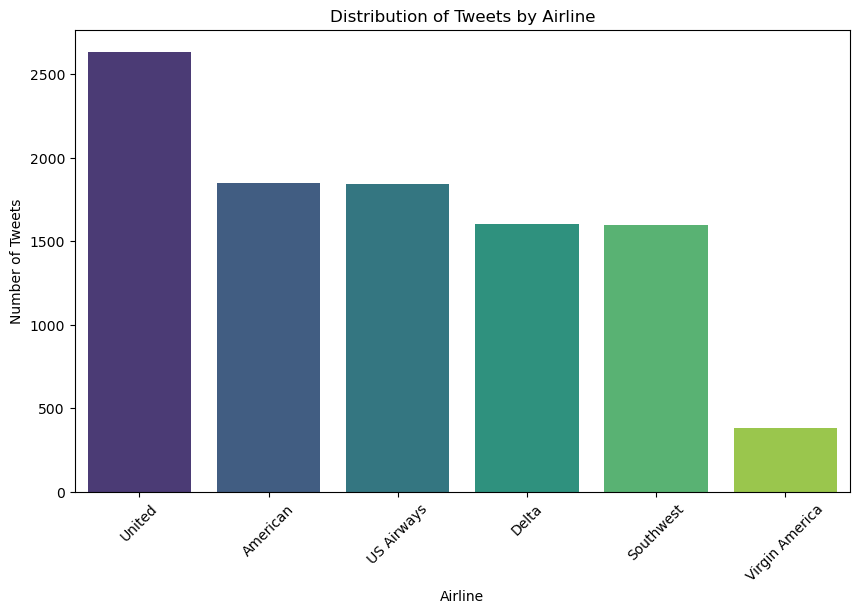

In [22]:
# Create a countplot to visualize the distribution of tweets by airline
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='airline', order=df['airline'].value_counts().index, palette='viridis')

# Set labels and title
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets by Airline')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

It seems like United Airlines has the most tweets by far, The rest are closely related expect Virgin America which is significantly lower than the rest. 

This makes sense as not only is it a budget airline, its relatively young and been defunct since 2018. 2004-2018 is not a long time compared to United for example which has been around for over 90 years.

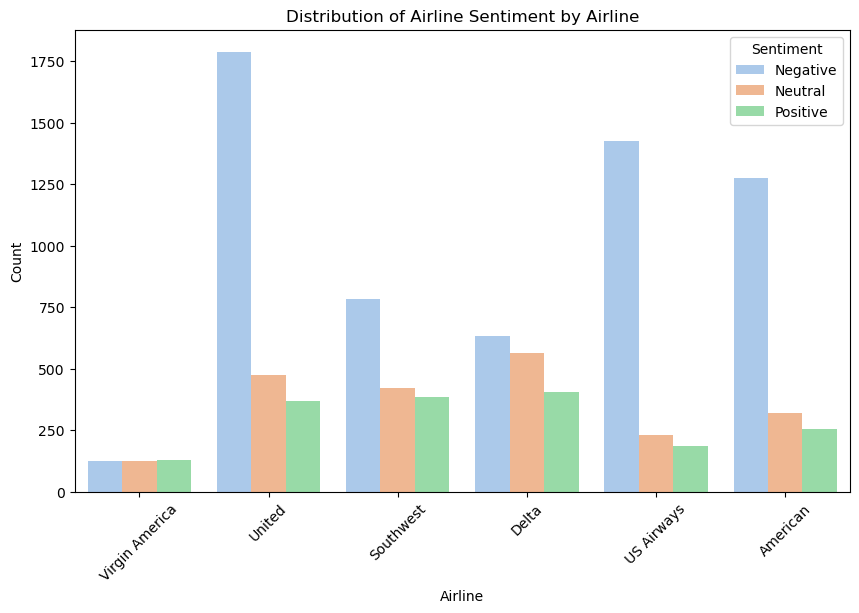

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a countplot to show the distribution of airline sentiment based on airlines
plt.figure(figsize=(10, 6))
sns.countplot(x="airline", hue="airline_sentiment", data=df, palette="pastel")
plt.title("Distribution of Airline Sentiment by Airline")
plt.xlabel("Airline")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.legend(title="Sentiment", labels=["Negative", "Neutral", "Positive"])
plt.show()


Again, the more prevelant airlines show their dominance. However theres a massive amount of negative reviews for them as well. Compared to Southwest and Delta which also have a majority negative but their set is much more balanced.

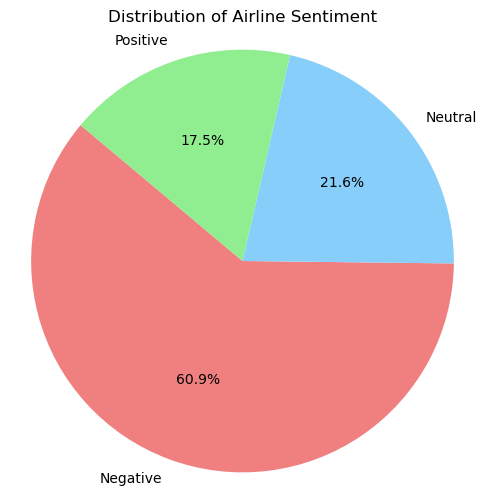

In [33]:
# Count the occurrences of each sentiment label
sentiment_counts = df['airline_sentiment'].value_counts()

# Define the custom labels
custom_labels = ['Negative', 'Neutral', 'Positive']

# Create a dictionary to map the existing labels to custom labels
label_mapping = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

# Apply the custom labels to the Series
sentiment_counts.index = sentiment_counts.index.map(label_mapping)

# Define colors
colors = ["lightcoral", "lightskyblue", "lightgreen"]

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=custom_labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Distribution of Airline Sentiment")
plt.axis('equal')
plt.show()

There are way more negative tweets than positive. This makes sense if you look at it from a psychological perspective; humans naturally like to complain or vent their frustrations. Im sure we all have been there where we bad mouthed a service we had recieved but its not often that were so estatic with the service that we recieve that we decide to post about it.

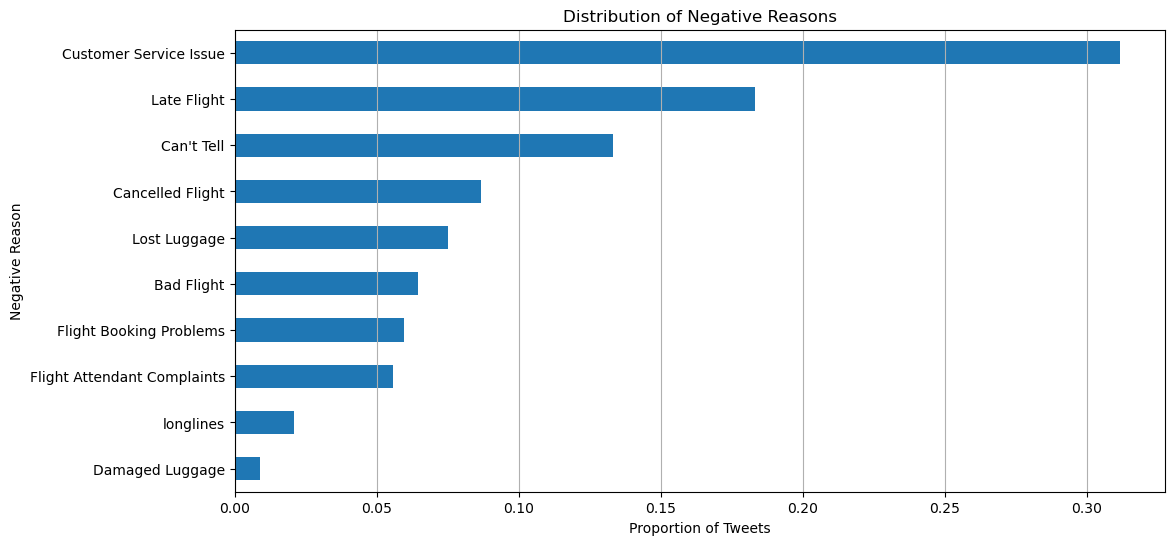

In [26]:
# Filter out the 'N/A' value
negative_reasons = df[df['negativereason'] != 'N/A']

# Calculate the proportions
proportions = negative_reasons['negativereason'].value_counts(normalize=True)

# Sort the proportions in descending order
proportions = proportions.sort_values(ascending=True)

# Create a horizontal bar chart
plt.figure(figsize=(12, 6))
proportions.plot(kind='barh')
plt.xlabel('Proportion of Tweets')
plt.ylabel('Negative Reason')
plt.title('Distribution of Negative Reasons')
plt.grid(axis='x')
plt.show()


Customer service issues cause most bad tweets and by a long shot. The rest pale in comparison. Late flights are especially frustrating as well. People make reservations, they create expectations, and when they are let down they deserve to be upset.

Focusing on reducing these two will likely greatly reduce negative reviews

# Pre-Processing

## Tokenization